## Machine Learning - assignment 2

-----
Carolina Pires, 202408704
Diogo Teixeira, 201705082
João Monteiro, 202108347


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [12]:
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
diagnosis_names = pd.read_csv('D_ICD_DIAGNOSES.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
icustays = pd.read_csv('ICUSTAYS.csv')
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)  

In [3]:
top_codes = diagnoses['ICD9_CODE'].value_counts().head(15).reset_index()
top_codes.columns = ['ICD9_CODE', 'count']

top_diseases = top_codes.merge(diagnosis_names[['ICD9_CODE', 'SHORT_TITLE']], on='ICD9_CODE', how='left')

print(top_diseases)

   ICD9_CODE  count               SHORT_TITLE
0       4019  20703          Hypertension NOS
1       4280  13111                   CHF NOS
2      42731  12891       Atrial fibrillation
3      41401  12429  Crnry athrscl natve vssl
4       5849   9119  Acute kidney failure NOS
5      25000   9058  DMII wo cmp nt st uncntr
6       2724   8690    Hyperlipidemia NEC/NOS
7      51881   7497  Acute respiratry failure
8       5990   6555  Urin tract infection NOS
9      53081   6326         Esophageal reflux
10      2720   5930   Pure hypercholesterolem
11      V053   5779  Need prphyl vc vrl hepat
12      V290   5519    NB obsrv suspct infect
13      2859   5406                Anemia NOS
14      2449   4917        Hypothyroidism NOS


In [4]:
#doença escolhida: Acute respiratry failure
diagnoses = diagnoses.merge(diagnosis_names, on='ICD9_CODE', how='left')
arf_cases = diagnoses[diagnoses['ICD9_CODE'] == '51881']
subject_ids = arf_cases['SUBJECT_ID'].unique()

In [5]:
admissions_filtered = admissions[admissions['SUBJECT_ID'].isin(subject_ids)]
icu_filtered = icustays[icustays['SUBJECT_ID'].isin(subject_ids)]
icu_filtered['LOS_DAYS'] = icu_filtered['LOS']  

/var/folders/4c/vj78xsmn3pb6_vt90ts9q5hr0000gn/T/ipykernel_96410/3161991954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_filtered['LOS_DAYS'] = icu_filtered['LOS']


In [6]:
print(f"Número de pacientes com ARF: {len(subject_ids)}")
print(f"Número de admissões em UCI: {len(icu_filtered)}")
print(icu_filtered[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS_DAYS']].head())

Número de pacientes com ARF: 6719
Número de admissões em UCI: 12973
    SUBJECT_ID  HADM_ID  ICUSTAY_ID  LOS_DAYS
0          268   110404      280836    3.2490
5          273   158689      241507    1.4862
7          275   129886      219649    7.1314
12         281   111199      257572    7.7389
14         283   109185      231490   30.6932


### pré-processamento

In [7]:
admissions_filtered['ADMITTIME'] = pd.to_datetime(admissions_filtered['ADMITTIME'])
admissions_filtered['DISCHTIME'] = pd.to_datetime(admissions_filtered['DISCHTIME'])
admissions_filtered = admissions_filtered.drop_duplicates()
icu_filtered = icu_filtered.drop_duplicates()

/var/folders/4c/vj78xsmn3pb6_vt90ts9q5hr0000gn/T/ipykernel_96410/1403208071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions_filtered['ADMITTIME'] = pd.to_datetime(admissions_filtered['ADMITTIME'])
/var/folders/4c/vj78xsmn3pb6_vt90ts9q5hr0000gn/T/ipykernel_96410/1403208071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions_filtered['DISCHTIME'] = pd.to_datetime(admissions_filtered['DISCHTIME'])


In [8]:
#tempo total de internamento
admissions_filtered['LENGTH_OF_STAY'] = (admissions_filtered['DISCHTIME'] - admissions_filtered['ADMITTIME']).dt.total_seconds() / (60*60*24)

In [9]:
#combinar admissões com estadias em UCI
merged_data = icu_filtered.merge(admissions_filtered, on=['SUBJECT_ID', 'HADM_ID'], how='left')

stats_by_patient = merged_data.groupby('SUBJECT_ID').agg(
    num_admissions=('HADM_ID', 'nunique'),
    total_icu_stays=('ICUSTAY_ID', 'nunique'),
    avg_icu_los=('LOS_DAYS', 'mean'),
    max_icu_los=('LOS_DAYS', 'max')
).reset_index()

print(stats_by_patient.head())

   SUBJECT_ID  num_admissions  total_icu_stays  avg_icu_los  max_icu_los
0          91               1                2      1.98575       3.4750
1         101               1                1      9.89190       9.8919
2         111               2                2      5.57100      10.5708
3         112               2                2      0.98970       1.1392
4         141               1                1      3.47650       3.4765


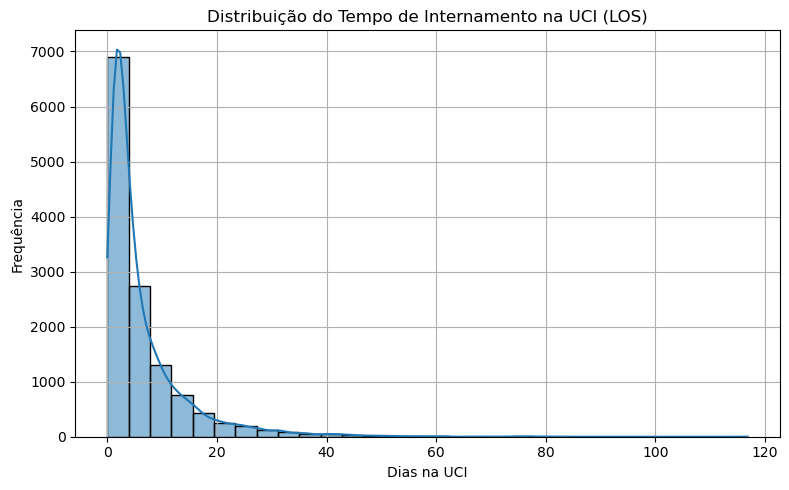

In [10]:
#distribuição de tempo de internamento na UCI
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['LOS_DAYS'], bins=30, kde=True)
plt.title("Distribuição do Tempo de Internamento na UCI (LOS)")
plt.xlabel("Dias na UCI")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()

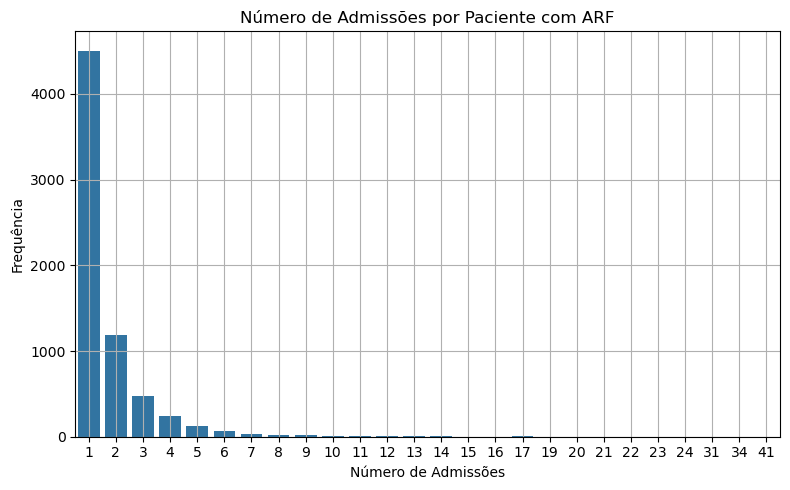

In [11]:
#número de admissões por paciente
plt.figure(figsize=(8, 5))
sns.countplot(x=stats_by_patient['num_admissions'])
plt.title("Número de Admissões por Paciente com ARF")
plt.xlabel("Número de Admissões")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()